In [ ]:
'''
Hi, I am Giuseppe Marinelli and this is the python code for my master thesis in which I tried to
assess the risk of wildfires with a ML model and remote sensing data.
Altough this implementation may not be the best, I have spent a lot of hours trying to figure things out.
Hopefully, the code that I share here, may one day help someone.

You can use my code without problems (maybe a little mention ?).

For further info you can contact me: g.marinelli@students.uu.nl.
'''

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Model, layers
from keras import backend as K
from keras.backend import clear_session
from random import randint
import matplotlib.pyplot as plt
import math
import pandas as pd
import pickle

from google.colab import drive
drive.mount('/content/drive')

# use this dataset
drive_path = '/data_path/'

tf.keras.mixed_precision.set_global_policy('mixed_float16')

Mounted at /content/drive
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


### Load train set

In [ ]:
def load_dataset(batch=32, buffer=200):
    # load the train dataset
    X_train = np.load(drive_path + 'Xdataset.npy.npz')['arr_0']
    X_train = X_train.transpose(0,2,3,1)
    Y_train = np.load(drive_path + 'Ydataset.npy.npz')['arr_0']

    Y_train = np.reshape(Y_train, (Y_train.shape[0],200,200,1))
    
    # load the eval dataset
    X_val = np.load(drive_path + 'Xdataset_val.npy.npz')['arr_0']
    X_val = X_val.transpose(0,2,3,1)
    Y_val = np.load(drive_path + 'Ydataset_val.npy.npz')['arr_0']

    Y_val = np.reshape(Y_val, (Y_val.shape[0], 200,200,1))
    
    # load datasets 
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    train_dataset = train_dataset.shuffle(buffer).batch(batch)
    val_dataset = val_dataset.batch(batch)
    
    return train_dataset, val_dataset

def load_rnd_dataset(size=200, batch=32, buffer=100):
    X_train = np.random.rand(20, size, size, 19)
    Y_train = np.ones((20, size, size))

    X_val = np.random.rand(4, size, size, 19)
    Y_val = np.ones((4, size, size))
    
    # load datasets 
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    train_dataset = train_dataset.shuffle(buffer).batch(batch)
    val_dataset = val_dataset.batch(batch)
    
    return train_dataset, val_dataset


# train_dataset, val_dataset = load_rnd_dataset()
train_dataset, val_dataset = load_dataset()

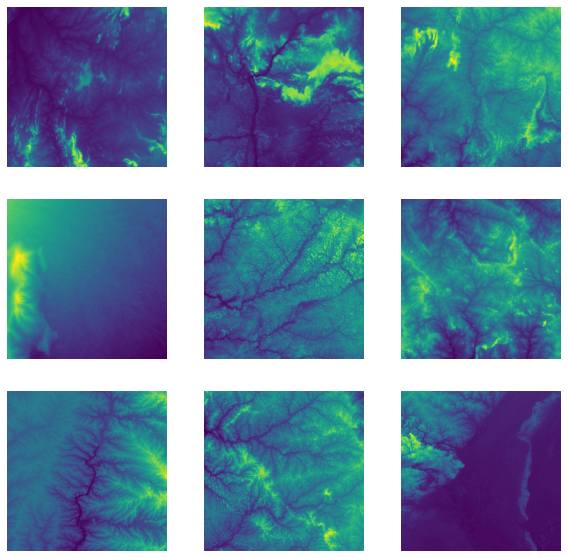

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    image = image_batch[i].numpy()

    plt.imshow(image[:,:,0])
    plt.axis("off")

### Define loss function and accuracies 

In [ ]:
def ratio_fires(y_true, y_pred):
    # returns the ratio between found fires and total fires
    y_truef = tf.where(y_true > 0.5, 1., 0.)
    y_predf = tf.where(y_pred > 0.5, 1., 0.)

    masked = y_truef * y_predf
    # res = tf.where(masked > 0.5, 1., 0.)

    return tf.reduce_sum(masked) / tf.reduce_sum(y_truef)

def ratio_no_fires(y_true, y_pred):
    # flip both arrays, 0 are the ones > 0.5
    y_truef = tf.where(y_true > 0.5, 0., 1.)
    y_predf = tf.where(y_pred > 0.5, 0., 1.)

    intersection = y_truef * y_predf

    return tf.reduce_sum(intersection) / tf.reduce_sum(y_truef)

smooth = 1

def dice_coef(y_true, y_pred):
    y_truef = tf.reshape(y_true,[-1])
    y_predf = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_truef * y_predf)
    dice = (2.0 * intersection) / (tf.reduce_sum(y_truef) + tf.reduce_sum(y_predf)) 

    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

smooth2 = smooth
def iou_coef(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = tf.reduce_mean((intersection + smooth2) / (union + smooth2))
    return iou

class CutDownBS(keras.callbacks.Callback):

    def __init__(self, patience=4):
        self.tracking = []
        self.patience = patience

    def on_epoch_end(self, epoch, logs=None):
        self.tracking.append(np.around(logs['ratio_fires'], decimals=4))

        np_arr = np.asarray(self.tracking)

        idx1 = 0
        idx2 = idx1 + 1

        for idx in range(0, len(np_arr)):
            if idx2 == len(np_arr):
                break
            
            if np_arr[idx1] == np_arr[idx2]:
                idx2 = idx2 + 1
                
                if((idx2 - idx1) >= self.patience):
                    self.model.stop_training = True
                    print('Stopping training ...')
            else:
                idx1 = idx2
                idx2 = idx2 + 1

### Train the CNN model

In [ ]:
clear_session()

def cnn(input_size=(200, 200, 20), dropout=0.1, lay_deep=2):
    inputs = layers.Input(input_size)

    x = layers.Conv2D(40, (7,7), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(60, (5,5), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    chann_deep = x.shape[-1]
    for l_d in range(0,lay_deep):
        chann_deep  += 10
        x = layers.Conv2D(chann_deep, (3,3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('tanh')(x)

    x = layers.Conv2D(30, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(1, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    model_output = layers.Conv2D(1, (1,1), activation='sigmoid', dtype=tf.float32)(x)
    
    return Model(inputs=[inputs], outputs=[model_output], name="model_cnn")

model_cnn = cnn(dropout=0.3, lay_deep=6)

# model_cnn.summary()

def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.2
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  math.floor((1+epoch)/epochs_drop))
   return lrate

initial_learning_rate = 0.0008

def lr_exp_decay(epoch, lr):
    k = 0.2
    return initial_learning_rate * math.exp(-k*epoch)

lrate_call = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)

model_cnn.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = dice_coef_loss, 
              metrics = [ratio_fires, ratio_no_fires, iou_coef, dice_coef])


logdir = drive_path
# file_name = 'model_cnn_0.6_0.3_no1'
file_name = 'modelz_try1'

callbacks = [lrate_call, keras.callbacks.ModelCheckpoint(logdir + file_name + '.hdf5', save_best_only=True,
                                             verbose=1, monitor='val_dice_coef', mode='max'), CutDownBS()]

# train the model
hist_model = model_cnn.fit(train_dataset, 
                       validation_data = val_dataset, 
                       epochs = 30,
                       callbacks=callbacks)

with open(logdir + file_name + '.pickle', 'wb') as handle:
            pickle.dump(hist_model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1: LearningRateScheduler setting learning rate to 0.0008.
Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.9958 - ratio_fires: 0.0692 - ratio_no_fires: 0.9263 - iou_coef: 0.0021 - dice_coef: 0.0041
Epoch 1: val_dice_coef improved from -inf to 0.00233, saving model to /content/drive/MyDrive/Colab_Notebooks/Thesis/20_c_norm/modelz_try1.hdf5
29/29 [==============================] - 150s 2s/step - loss: 0.9958 - ratio_fires: 0.0692 - ratio_no_fires: 0.9263 - iou_coef: 0.0021 - dice_coef: 0.0041 - val_loss: 0.9977 - val_ratio_fires: 0.0000e+00 - val_ratio_no_fires: 1.0000 - val_iou_coef: 0.0012 - val_dice_coef: 0.0023 - lr: 8.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0006549846024623855.
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.9957 - ratio_fires: 0.0000e+00 - ratio_no_fires: 1.0000 - iou_coef: 0.0021 - dice_coef: 0.0043
Epoch 2: val_dice_coef improved from 0.00233 to 0.01082, saving model to /content/drive/M

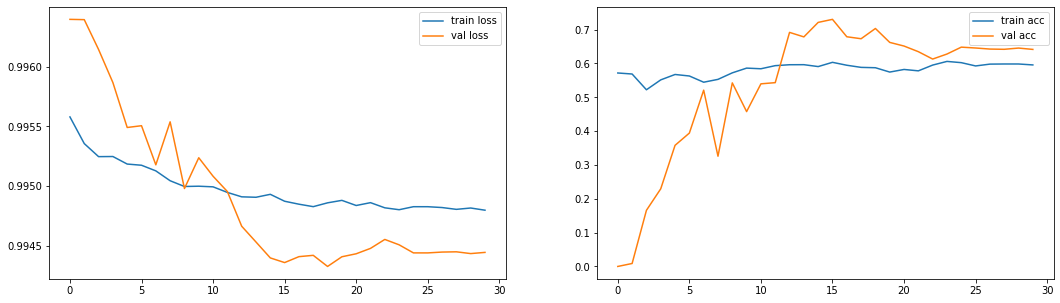

In [ ]:
arr = [hist_model.history['loss'], hist_model.history['val_loss'], hist_model.history['ratio_fires'], hist_model.history['val_ratio_fires'], ]
labels = ['train loss', 'val loss', 'train acc', 'val acc']

count=1
for col in range(0,2):
    plt.subplot(1, 2, count)

    idx = col * 2 
    
    plt.plot(arr[idx], label=labels[idx])
    plt.plot(arr[idx + 1], label=labels[idx + 1])

    count += 1
    plt.legend()

plt.gcf().set_size_inches(18, 5)

plt.show()

##### CNNS

In [ ]:
# cnn1 = 120 - 4 deep 

### Train U_net

In [ ]:
def unet(input_size=(200, 200, 20)):
    inputs = layers.Input(input_size)
    
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = layers.BatchNormalization(axis=3)(conv1)
    bn1 = layers.Activation('relu')(bn1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = layers.BatchNormalization(axis=3)(conv2)
    bn2 = layers.Activation('relu')(bn2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = layers.BatchNormalization(axis=3)(conv3)
    bn3 = layers.Activation('relu')(bn3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = layers.BatchNormalization(axis=3)(conv4)
    bn4 = layers.Activation('relu')(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = layers.BatchNormalization(axis=3)(conv5)
    bn5 = layers.Activation('relu')(bn5)

    up6 = layers.concatenate([layers.Conv2DTranspose(512, (3, 3), strides=(2, 2))(bn5), conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = layers.BatchNormalization(axis=3)(conv6)
    bn6 = layers.Activation('relu')(bn6)

    up7 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = layers.BatchNormalization(axis=3)(conv7)
    bn7 = layers.Activation('relu')(bn7)

    up8 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = layers.BatchNormalization(axis=3)(conv8)
    bn8 = layers.Activation('relu')(bn8)

    up9 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = layers.BatchNormalization(axis=3)(conv9)
    bn9 = layers.Activation('relu')(bn9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid', dtype=tf.float32)(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

model_u = unet()
model_u.summary()

model_u.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.6), 
                loss = dice_coef_loss, 
                metrics = [ratio_fires, ratio_no_fires, iou_coef, dice_coef])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 2  0           []                               
                                0)]                                                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 200, 200, 64  11584       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 activation_10 (Activation)     (None, 200, 200, 64  0           ['conv2d_11[0][0]']              
                                )                                                             

NameError: ignored

In [ ]:
callbacks_u = [keras.callbacks.ModelCheckpoint(drive_path + 'model_u_thesis.hdf5', save_best_only=True,
                                             verbose=1, monitor='val_dice_coef', mode='max'), CutDownBS()]

hist_model_u = model_u.fit(train_dataset, 
                           validation_data = val_dataset, 
                           epochs = 30,
                           use_multiprocessing=True, 
                           workers=6, 
                           callbacks=callbacks_u)

## Train Autoencoder

In [ ]:
def autoenc(input_size=(200, 200, 20)):
    inputs = layers.Input(input_size)

    # encoder
    conv1_1 = layers.Conv2D(40, (5, 5), activation='tanh', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2, 2), padding='same')(conv1_1)
    conv1_2 = layers.Conv2D(20, (3, 3), activation='tanh', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2, 2), padding='same')(conv1_2)
    conv1_3 = layers.Conv2D(5, (3, 3), activation='tanh', padding='same')(pool2)
    h = layers.MaxPooling2D((2, 2), padding='same')(conv1_3)
    
    # Decoder
    conv2_1 = layers.Conv2D(5, (3, 3), activation='tanh', padding='same')(h)
    up1 = layers.UpSampling2D((2, 2))(conv2_1)
    conv2_2 = layers.Conv2D(20, (3, 3), activation='tanh', padding='same')(up1)
    up2 = layers.UpSampling2D((2, 2))(conv2_2)
    conv2_3 = layers.Conv2D(40, (3, 3), activation='tanh', padding='same')(up2)
    up3 = layers.UpSampling2D((2, 2))(conv2_3)
    r = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same', dtype=tf.float32)(up3)
    
    return Model(inputs=[inputs], outputs=[r])

model_auto = autoenc()
model_auto.summary()

model_auto.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.6), 
                loss = dice_coef_loss, 
                metrics = [ratio_fires, ratio_no_fires, iou_coef, dice_coef])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 20)]    0         
                                                                 
 conv2d_30 (Conv2D)          (None, 200, 200, 40)      20040     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 40)     0         
 2D)                                                             
                                                                 
 conv2d_31 (Conv2D)          (None, 100, 100, 20)      7220      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 20)       0         
 2D)                                                             
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 50, 5)         905 

NameError: ignored

In [ ]:
callbacks_u = [keras.callbacks.ModelCheckpoint(drive_path + 'model_auto.hdf5', save_best_only=True,
                                             verbose=1, monitor='val_dice_coef', mode='max'), CutDownBS()]

hist_model_auto = model_auto.fit(train_dataset, 
                                validation_data = val_dataset, 
                                epochs = 30,
                                use_multiprocessing=True, 
                                workers=6, 
                                callbacks=callbacks_u)

Epoch 1/30


ValueError: ignored

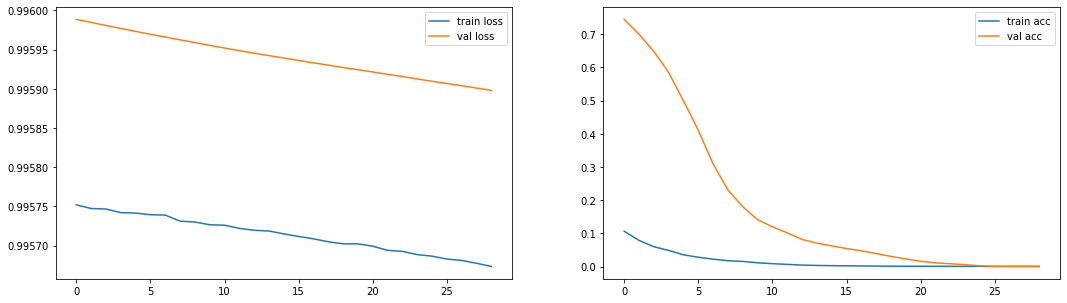

In [ ]:
arr = [hist_model_auto.history['loss'], hist_model_auto.history['val_loss'], hist_model_auto.history['ratio_fires'], hist_model_auto.history['val_ratio_fires'], ]
labels = ['train loss', 'val loss', 'train acc', 'val acc']

count=1
for col in range(0,2):
    plt.subplot(1, 2, count)

    idx = col * 2 
    
    plt.plot(arr[idx], label=labels[idx])
    plt.plot(arr[idx + 1], label=labels[idx + 1])

    count += 1
    plt.legend()

plt.gcf().set_size_inches(18, 5)

plt.show()

## Test/verify the model

In [ ]:
# load model
# load_model = tf.keras.models.load_model(drive_path + 'model_cnn_best_6_0.3.hdf5')

model_cnn.load_weights(drive_path + 'model_cnn_best_6_0.3.hdf5')

In [ ]:
X_val = np.load(drive_path + 'Xdataset_val.npy.npz')['arr_0']
Y_val = np.load(drive_path + 'Ydataset_val.npy.npz')['arr_0']

index:  142
(200, 200, 20)


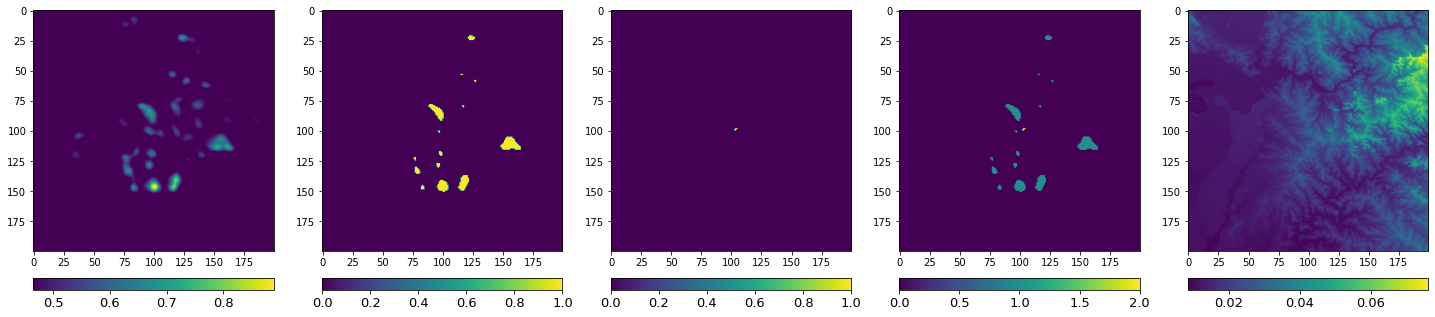

In [ ]:
def compute_label(sample):
    #  format the sample

    tmp_np = np.moveaxis(sample, 0, 2)

    print(tmp_np.shape)

    tmp_np = np.reshape(tmp_np, [1, tmp_np.shape[0], tmp_np.shape[1], tmp_np.shape[2]])

    test_label = model_cnn.predict(tmp_np)

    return test_label[0,:,:,0]

# tep = np.zeros((20,200,200))
idx = randint(0, X_val.shape[0]-1)

# idx = 44
print("index: ", idx)
y_true = Y_val[idx]
y_pred = X_val[idx]
y_predic = compute_label(y_pred)

y_pred2 = y_predic.copy()
y_pred2[y_pred2 >= 0.6] = 1
y_pred2[y_pred2 < 0.6] = 0

array = [y_predic, y_pred2, y_true, (y_pred2 + y_true*2), X_val[idx][0]]

count = 1

for col in array:
    plt.subplot(1, 5, count)
    
    plt.imshow(col)
    cbar = plt.colorbar(orientation="horizontal", pad=0.02)
    cbar.ax.tick_params(labelsize=13)
    count +=1

plt.gcf().set_size_inches(25, 25)